In [106]:
%load_ext autoreload
%autoreload 2

import torch
import logging
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable


import os, sys
sys.path.append(os.path.join(os.getcwd(), '../..'))

from emlp.groups import Z,S,SO,O,O13,SO13,RubiksCube, noise2samples


logger = logging.getLogger()
logger.setLevel(logging.INFO)
logging.debug("test")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Constructing Equivariant Models

Previously we showed examples of finding equivariant bases for different groups and representations, now we'll show how these bases can be assembled into equivariant neural networks such as EMLP. 

We will give examples at a high level showing how the specific EMLP model can be applied to different groups and input-output types, and later in a lower level showing how models like EMLP can be constructed with equivariant layers and making use of the equivariant bases.

## Using EMLP with different groups and representations (high level)

![ex 2.13](imgs/EMLP_fig.png)

A basic EMLP is a sequence of EMLP layers (containing G-equivariant linear layers, bilinear layers incorporated with a shortcut connection, and gated nonlinearities. While our numerical equivariance solver can work with any finite dimensional linear representation, for EMLP we restrict ourselves to _tensor_ representations.

By tensor representations, we mean all representations which can be formed by arbitrary combinations of $\oplus$,$\otimes$,$^*$ (`+`,`*`,`.T`) of a base representation $\rho$. This is useful because it simplifies the construction of our bilinear layer, which is a crucial ingredient for expressiveness and universality in EMLP.

Following the $T_{(p,q)}=V^{\otimes p}\otimes (V^*)^{\otimes p}$ notation in the paper, we provide the convenience function for constructing higher rank tensors.

In [77]:
from emlp.reps import V, Scalar, Vector, vis
from emlp.groups import SO13

def T(p,q=0):
    return (V**p*V.T**q)

print(T(2,3))
print(T(2,3)(SO13()))

V⊗V⊗V*⊗V*⊗V*
V²⊗V*³


Lets get started with a toy dataset: learning how an inertia matrix depends on the positions and masses of 5 point masses distributed in different ways. The data consists of mappings (positions, masses) --> (inertia matrix) pairs, and has an $G=O(3)$ symmetry (3D rotation and reflections). If we rotate all the positions, the resulting inertia matrix should be correspondingly rotated.

In [78]:
from emlp.datasets import Inertia
from emlp.groups import SO,O,S,Z

trainsize, testsize = 1000, 2000 # original size
trainsize, testsize = 100, 200   # tiny set for development

trainset = Inertia(trainsize) # Initialize dataset with 1000 examples
testset  = Inertia(testsize)
G = SO(3)
# G = Z(3)

print(f"Input type: {trainset.rep_in(G)}, output type: {trainset.rep_out(G)}")

(5V⁰+V+V+V+V+V)
(5V⁰+V+V+V+V+V)
Input type: 5V⁰+5V, output type: V⁰⊗V²


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([[0, 0, 0],
       [0, 0, 0],
       [0, 0, 0]], dtype=int32)

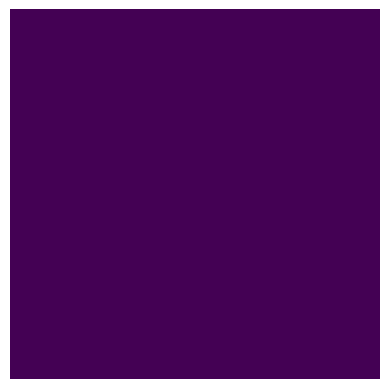

In [79]:
# G = Z(16)

repin = V(G)
repout = V(G)
vis(repin,repout)

For convenience, we store in the dataset the types for the input and the output. `5V⁰` are the $5$ mass values and `5V` are the position vectors of those masses, `V²` is the matrix type for the output, equivalent to $T_2$. To initialize the [EMLP](https://emlp.readthedocs.io/en/latest/package/emlp.nn.html#emlp.nn.EMLP), we just need these input and output representations, the symmetry group, and the size of the network as parametrized by number of layers and number of channels (the dimension of the feature representation).

In [86]:
import emlp
# model = emlp.nn.EMLP(trainset.rep_in,trainset.rep_out,group=G,num_layers=3,ch=384)
model = emlp.nn.EMLP(trainset.rep_in,trainset.rep_out,group=G,num_layers=3,ch=25)
# uncomment the following line to instead try the MLP baseline
#model = emlp.nn.MLP(trainset.rep_in,trainset.rep_out,group=G,num_layers=3,ch=384)

INFO:root:Initing EMLP (objax)
INFO:root:Reps: [5V⁰+5V, 13V⁰+2V+2V⁰⊗V, 13V⁰+2V+2V⁰⊗V, 13V⁰+2V+2V⁰⊗V]
INFO:root:Adding gates to 13V⁰+2V+2V⁰⊗V, chrep is SumRep
INFO:root:Linear W components:580 rep:85V⁰+85V+10V⁰²⊗V+10V⁰⊗V+10V²+10V⁰⊗V²
INFO:root:Adding gates to 13V⁰+2V+2V⁰⊗V, chrep is SumRep
INFO:root:Adding gates to 13V⁰+2V+2V⁰⊗V, chrep is SumRep
INFO:root:BiW components: dim:204
INFO:root:Adding gates to 13V⁰+2V+2V⁰⊗V, chrep is SumRep
INFO:root:Linear W components:725 rep:221V⁰+34V+26V⁰²⊗V+60V⁰⊗V+4V²+8V⁰⊗V²+4V⁰²⊗V²
INFO:root:Adding gates to 13V⁰+2V+2V⁰⊗V, chrep is SumRep
INFO:root:Adding gates to 13V⁰+2V+2V⁰⊗V, chrep is SumRep
INFO:root:BiW components: dim:204
INFO:root:Adding gates to 13V⁰+2V+2V⁰⊗V, chrep is SumRep
INFO:root:Linear W components:725 rep:221V⁰+34V+26V⁰²⊗V+60V⁰⊗V+4V²+8V⁰⊗V²+4V⁰²⊗V²
INFO:root:Adding gates to 13V⁰+2V+2V⁰⊗V, chrep is SumRep
INFO:root:Adding gates to 13V⁰+2V+2V⁰⊗V, chrep is SumRep
INFO:root:BiW components: dim:204
INFO:root:Linear W components:225 rep:13V⁰²⊗V

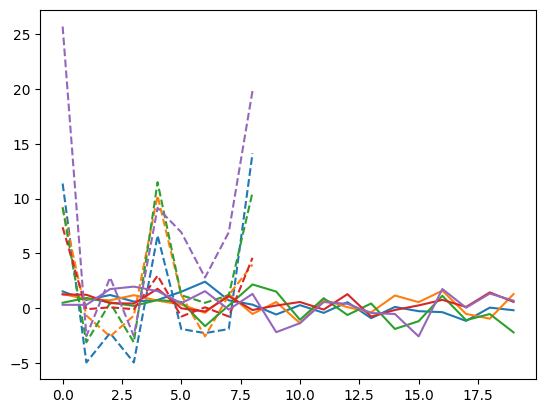

In [87]:
xs, ys = trainset[:5]
for i, (x, y) in enumerate(zip(xs, ys)):
    plt.plot(x, color = f'C{i}')
    plt.plot(y, color = f'C{i}', linestyle='--')
plt.show()

In [88]:
layer = model.network[0].linear
out = layer(x)
x.shape, out.shape

((20,), (29,))

In [103]:
ones = np.ones_like(layer.w.value.reshape(-1))

layer.Pw @ ones

Array([ 1.0000000e+00,  1.0000000e+00,  1.0000000e+00,  1.0000000e+00,
        1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        1.0000000e+00,  1.0000000e+00,  1.0000000e+00,  1.0000000e+00,
        1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        1.0000000e+00,  1.0000000e+00,  1.0000000e+00,  1.0000000e+00,
        1.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
        0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
      

In [132]:
layer.w.shape, layer.Pw.shape, 29*20

((29, 20), (580, 580), 580)

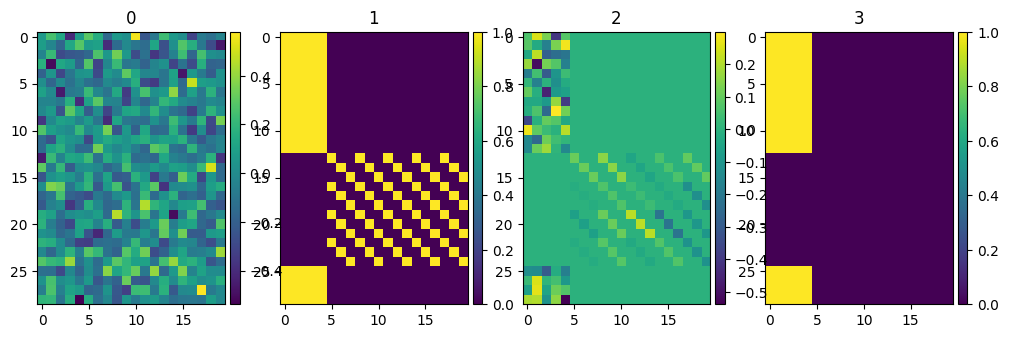

In [111]:
xs = [
    layer.w.value,
    (layer.Pw@np.ones_like(layer.w.value.reshape(-1))).reshape(*layer.w.value.shape),
    (layer.Pw@layer.w.value.reshape(-1)).reshape(*layer.w.value.shape),
]

xs += [xs[0] == xs[2]]

fig, axs = plt.subplots(1,len(xs),figsize=(12,4))
axs = axs.flatten()

for i, x in enumerate(xs):
    ax = axs[i]
    im = ax.imshow(x)
    ax.set_title(f"{i}")
    
    # set ssmall colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.show()

In [166]:
Q = layer.rep_W.equivariant_basis()


(580, 105)

/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


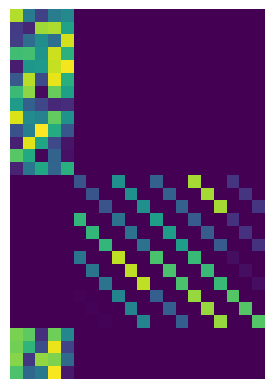

In [158]:
v = vis(layer.repin, layer.repout)

In [124]:
np.ones_like(layer.w.value.reshape(-1)).shape

(580,)

In [137]:
w.size

6

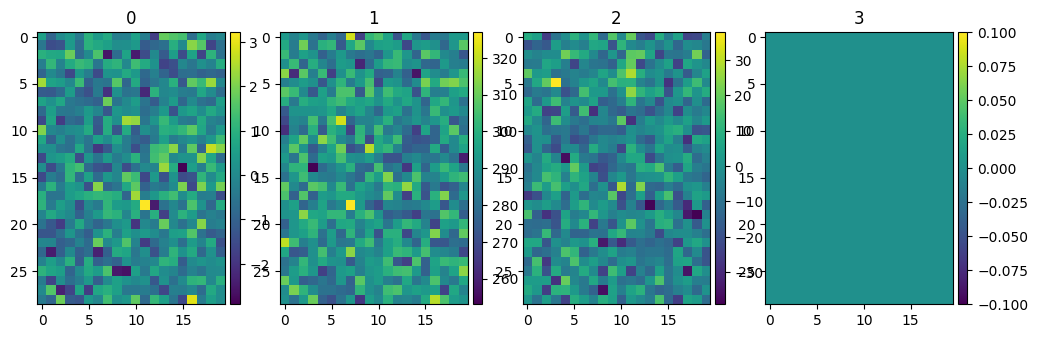

In [144]:
# w = np.array([[1,2,3],[4,5,6]])
# Pw = np.random.randn(w.size, w.size)

w = np.random.randn(29,20)
Pw = np.random.randint(0, 2, size = (w.size, w.size))


xs = [
    w,
    (Pw@np.ones_like(w.reshape(-1))).reshape(*w.shape),
    (Pw@w.reshape(-1)).reshape(*w.shape),
]

xs += [xs[0] == xs[2]]

fig, axs = plt.subplots(1,len(xs),figsize=(12,4))
axs = axs.flatten()

for i, x in enumerate(xs):
    ax = axs[i]
    im = ax.imshow(x)
    ax.set_title(f"{i}")
    
    # set ssmall colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.show()

In [129]:
a = np.array([[1,2,3],[4,5,6],[7,8,9]])
b = np.array([1,2,3])
print(a.shape, b.shape)

(a@b) == np.array([1*1+2*2+3*3, 4*1+5*2+6*3, 7*1+8*2+9*3])

(3, 3) (3,)


array([ True,  True,  True])

In [123]:
layer.Pw.shape

(580, 580)

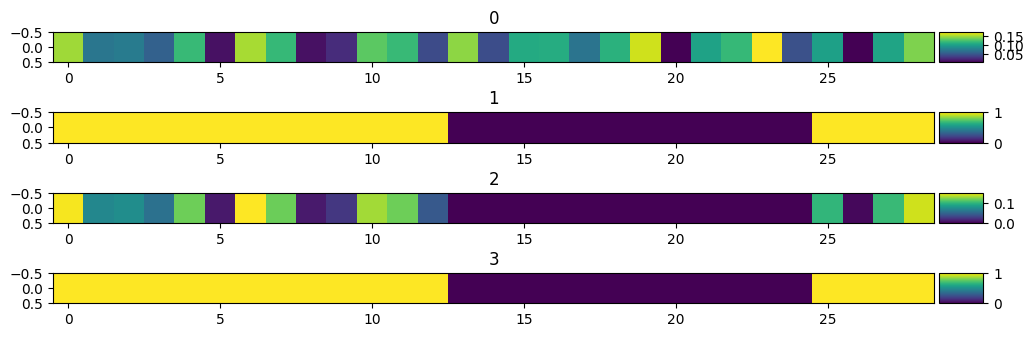

In [122]:
xs = [
    layer.b.value,
    (layer.Pb@np.ones_like(layer.b.value.reshape(-1))).reshape(*layer.b.value.shape),
    (layer.Pb@layer.b.value.reshape(-1)).reshape(*layer.b.value.shape),
]

xs += [xs[0] == xs[2]]

fig, axs = plt.subplots(len(xs),1,figsize=(12,4))
axs = axs.flatten()

for i, x in enumerate(xs):
    ax = axs[i]
    im = ax.imshow(x.reshape(1, -1))
    ax.set_title(f"{i}")
    
    # set ssmall colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

plt.show()

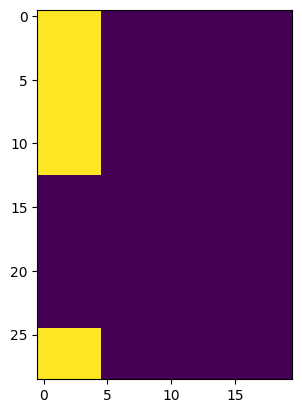

In [109]:
plt.imshow(xs[0] == xs[2])

## Example Objax Training Loop

We build our EMLP model with [objax](https://objax.readthedocs.io/en/latest/) because we feel the object oriented design makes building complicated layers easier. Below is a minimal training loop that you could use to train EMLP.

In [81]:
BS=500
lr=3e-3
NUM_EPOCHS=500 # original
NUM_EPOCHS=50

import objax
import jax.numpy as jnp
import numpy as np
from tqdm.auto import tqdm
from torch.utils.data import DataLoader


opt = objax.optimizer.Adam(model.vars())

@objax.Jit
@objax.Function.with_vars(model.vars())
def loss(x, y):
    yhat = model(x)
    return ((yhat-y)**2).mean()

grad_and_val = objax.GradValues(loss, model.vars())

@objax.Jit
@objax.Function.with_vars(model.vars()+opt.vars())
def train_op(x, y, lr):
    g, v = grad_and_val(x, y)
    opt(lr=lr, grads=g)
    return v

trainloader = DataLoader(trainset,batch_size=BS,shuffle=True)
testloader = DataLoader(testset,batch_size=BS,shuffle=True)

In [82]:
test_losses = []
train_losses = []
for epoch in tqdm(range(NUM_EPOCHS)):
    train_losses.append(np.mean([train_op(jnp.array(x),jnp.array(y),lr) for (x,y) in trainloader]))
    if not epoch%10:
        test_losses.append(np.mean([loss(jnp.array(x),jnp.array(y)) for (x,y) in testloader]))

100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


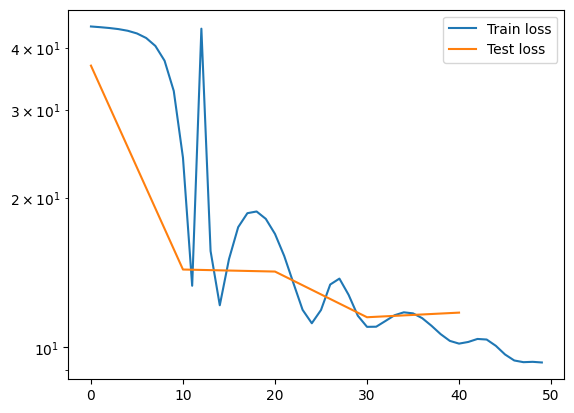

In [83]:
import matplotlib.pyplot as plt
plt.plot(np.arange(NUM_EPOCHS),train_losses,label='Train loss')
plt.plot(np.arange(0,NUM_EPOCHS,10),test_losses,label='Test loss')
plt.legend()
plt.yscale('log')

In [7]:
from jax import vmap
def rel_err(a,b):
    return jnp.sqrt(((a-b)**2).mean())/(jnp.sqrt((a**2).mean())+jnp.sqrt((b**2).mean()))#

rin,rout = trainset.rep_in(G),trainset.rep_out(G)

def equivariance_err(mb):
    x,y = mb
    x,y= jnp.array(x),jnp.array(y)
    gs = G.samples(x.shape[0])
    rho_gin = vmap(rin.rho_dense)(gs)
    rho_gout = vmap(rout.rho_dense)(gs)
    y1 = model((rho_gin@x[...,None])[...,0],training=False)
    y2 = (rho_gout@model(x,training=False)[...,None])[...,0]
    return rel_err(y1,y2)

As expected, the network continues to be equivariant as it is trained.

In [8]:
print(f"Average test equivariance error {np.mean([equivariance_err(mb) for mb in testloader]):.2e}")

Average test equivariance error 4.34e-07


## Breaking EMLP down into equivariant layers (mid level)

Internally for EMLP, we use representations that [uniformly allocate dimensions](https://emlp.readthedocs.io/en/latest/package/emlp.models.mlp.html#emlp.models.uniform_rep) between different tensor representations.

In [9]:
from emlp.nn import uniform_rep
r = uniform_rep(512,G)
print(r)

122V⁰+40V+12V²+3V³+V⁴


Below is a trimmed down version of EMLP, so you can see how it is built from the component layers `Linear`, `BiLinear`, and `GatedNonlinearities`. These layers can be constructed like ordinary objax modules, using the input and output representations.

In [12]:
from objax.module import Module

class EMLPBlock(Module):
    """ Basic building block of EMLP consisting of G-Linear, biLinear,
        and gated nonlinearity. """
    def __init__(self,rep_in,rep_out):
        super().__init__()
        rep_out_wgates = emlp.nn.gated(rep_out)
        self.linear = emlp.nn.Linear(rep_in,rep_out_wgates)
        self.bilinear = emlp.nn.BiLinear(rep_out_wgates,rep_out_wgates)
        self.nonlinearity = emlp.nn.GatedNonlinearity(rep_out)
    def __call__(self,x):
        lin = self.linear(x)
        preact =self.bilinear(lin)+lin
        return self.nonlinearity(preact)

class EMLP(Module):
    def __init__(self,rep_in,rep_out,group,ch=384,num_layers=3):
        super().__init__()
        reps = [rep_in(group)]+num_layers*[uniform_rep(ch,group)]
        self.network = emlp.nn.Sequential(
            *[EMLPBlock(rin,rout) for rin,rout in zip(reps,reps[1:])],
            emlp.nn.Linear(reps[-1],rep_out(group))
        )
    def __call__(self,x,training=True):
        return self.network(x)

The representations of the hidden layers (taking place of the number of channels in a standard MLP) is by default given by this `uniform_rep` shown above. Unlike this pedagogical implementation you can specify the representation of the hidden layers directly in the [full EMLP](https://emlp.readthedocs.io/en/latest/package/emlp.nn.html#emlp.nn.EMLP) by feeding in a representation to the `ch` argument, or even a list of representations to specify each hidden layer.

Note that since we are using the `GatedNonlinearity`, additional scalar gate channels need to be added to the output representation for the layer directly before the nonlinearity (in this case the `Linear` layer) which can be achieved with the `gated` function.

## The equivariant linear layers (low level)

At a lower level, the implementation of the `Linear` is fairly straightforward. An unconstrained bias `b` and weight matrix `w` are initialized. The projection matrices $P_b$ and $P_w$ are computed which are used project onto the symmetric subspace for each. Finally, during the forward pass, the unconstrained parameters are reshaped to vectors, projected via the matrices, and reshaped back to the original sizes. Then these projected parameters are applied to the input like a standard linear layer.

In [13]:
from objax.variable import TrainVar
from objax.nn.init import orthogonal

class Linear(Module):
    """ Basic equivariant Linear layer from repin to repout."""
    def __init__(self, repin, repout):
        nin,nout = repin.size(),repout.size()
        self.b = TrainVar(objax.random.uniform((nout,))/jnp.sqrt(nout))
        self.w = TrainVar(orthogonal((nout, nin)))
        self.rep_W = rep_W = repout*repin.T
        
        self.Pb = repout.equivariant_projector() # the bias vector has representation repout
        self.Pw = rep_W.equivariant_projector()
        
    def __call__(self, x):
        W = (self.Pw@self.w.value.reshape(-1)).reshape(*self.w.value.shape)
        b = self.Pb@self.b.value
        return x@W.T+b